In [1]:
# install required packages for the project
!pip install -q scikit-learn pandas numpy imbalanced-learn matplotlib seaborn joblib shap


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# imports + load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import joblib

pd.set_option('display.max_columns', None)
print("pandas, sklearn, imblearn versions:", pd.__version__)
# Load dataset - change path if needed
df = pd.read_csv("creditcard.csv")
print("Loaded shape:", df.shape)
print("Class distribution (counts):\n", df['Class'].value_counts())
print("Class distribution (proportions):\n", df['Class'].value_counts(normalize=True))
print(df.head())


pandas, sklearn, imblearn versions: 2.3.3
Loaded shape: (284807, 31)
Class distribution (counts):
 Class
0    284315
1       492
Name: count, dtype: int64
Class distribution (proportions):
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643

In [3]:
# cleaning + checks
print("Missing values per column:\n", df.isnull().sum().sort_values(ascending=False).head(20))
# If missing are negligible, drop them:
df = df.dropna().reset_index(drop=True)
print("After dropna shape:", df.shape)


Missing values per column:
 Time    0
V1      0
V2      0
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
V10     0
V11     0
V12     0
V13     0
V14     0
V15     0
V16     0
V17     0
V18     0
V19     0
dtype: int64
After dropna shape: (284807, 31)


In [ ]:
# simulate behavior features (deterministic seed for reproducibility)
np.random.seed(42)
n = df.shape[0]

# Simulate user_id: adjust n_users as desired
n_users = 5000
df['user_id'] = np.random.choice(np.arange(n_users), size=n)

# Stimulate device category distribution
df['device'] = np.random.choice(['mobile','desktop','tablet'], size=n, p=[0.6,0.35,0.05])

# Simulate login_hour (0-23). Optionally correlate fraud with late-night hours later.
df['login_hour'] = np.random.randint(0,24,size=n)

# Aggregate per user: user_total_tx
user_counts = df['user_id'].value_counts().rename('user_total_tx')
df = df.merge(user_counts, left_on='user_id', right_index=True)

# session_count_24h: simulate based on user_total_tx
df['session_count_24h'] = (np.random.poisson(1, size=n) + (df['user_total_tx'] > 5).astype(int))

# device_change_count: small poisson noise + occasional changes
df['device_change_count'] = np.random.poisson(0.2, size=n) + (np.random.rand(n) < 0.05).astype(int)

print("Sample of behavioral columns:\n", df[['user_id','device','login_hour','user_total_tx','session_count_24h','device_change_count']].head())


Sample of behavioral columns:
    user_id   device  login_hour  user_total_tx  session_count_24h  \
0      860  desktop           4             52                  1   
1     3772   mobile          16             50                  1   
2     3092   mobile          18             62                  2   
3      466   tablet           5             52                  2   
4     4426  desktop          15             58                  1   

   device_change_count  
0                    0  
1                    0  
2                    0  
3                    0  
4                    1  


In [5]:
# encode categorical features
# One-hot for device
df = pd.get_dummies(df, columns=['device'], drop_first=True)

# Label encode user_id for tree models (for sequence models we'll treat differently)
le = LabelEncoder()
df['user_id_enc'] = le.fit_transform(df['user_id'])

# build features list (V1..V28, Time, Amount + behavioral features)
features = [f"V{i}" for i in range(1,29)] + ['Time','Amount',
            'session_count_24h','device_change_count','login_hour',
            'device_desktop','device_tablet','user_id_enc']

# keep only available cols to avoid errors
features = [c for c in features if c in df.columns]
print("Number of features selected:", len(features))
print("First 20 features:", features[:20])
X = df[features]
y = df['Class'].astype(int)
print("Feature matrix shape:", X.shape, "Target shape:", y.shape)


Number of features selected: 35
First 20 features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20']
Feature matrix shape: (284807, 35) Target shape: (284807,)


In [6]:
# scale Time and Amount
scaler = StandardScaler()
to_scale = [c for c in ['Time','Amount'] if c in X.columns]
if to_scale:
    X[to_scale] = scaler.fit_transform(X[to_scale])
    print("Scaled columns:", to_scale)
else:
    print("No Time/Amount found to scale.")
# Optionally persist scaler after training

Scaled columns: ['Time', 'Amount']


C:\Users\Shashwat\AppData\Local\Temp\ipykernel_23348\2685350633.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[to_scale] = scaler.fit_transform(X[to_scale])


In [9]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class ratio:", y_train.mean(), "Test class ratio:", y_test.mean())


Train shape: (227845, 35) Test shape: (56962, 35)
Train class ratio: 0.001729245759178389 Test class ratio: 0.0017204452090867595


In [10]:
# Sampling strategy toggle
USE_SMOTE = False   # <-- set True to use SMOTE oversampling (may increase memory/time)
SMOTE_PROPORTION = 0.1  # if SMOTE, minority will be this fraction of majority (0.1 = 10%)

if USE_SMOTE:
    print("Using SMOTE. This may increase dataset size.")
    sm = SMOTE(sampling_strategy=SMOTE_PROPORTION, random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("After SMOTE, X_train_res shape:", X_train_res.shape, "pos ratio:", y_train_res.mean())
else:
    print("Using class_weight='balanced' (no resampling).")
    X_train_res, y_train_res = X_train, y_train


Using class_weight='balanced' (no resampling).


Training RandomForest...
Training done.
Classification report:
               precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9610    0.7551    0.8457        98

    accuracy                         0.9995     56962
   macro avg     0.9803    0.8775    0.9227     56962
weighted avg     0.9995    0.9995    0.9995     56962

Confusion matrix:
 [[56861     3]
 [   24    74]]
ROC AUC: 0.9572128953579181


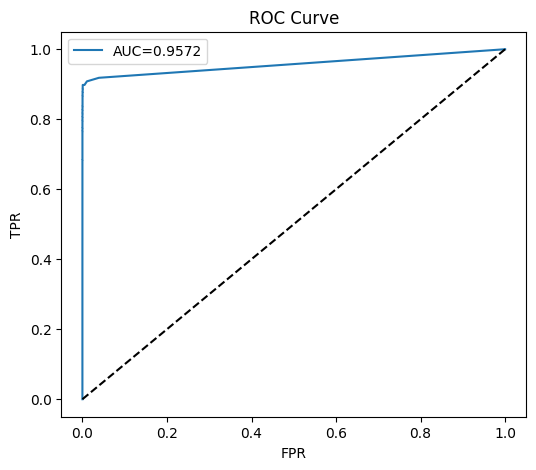

In [12]:
# train & evaluate
clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced' if not USE_SMOTE else None
)

print("Training RandomForest...")
clf.fit(X_train_res, y_train_res)
print("Training done.")

# Predictions and metrics
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("Classification report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# ROC plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test,y_proba):.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
plt.show()
